In [22]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
 
import tensorflow as tf
import pandas as pd
 
from tensorflow.python.platform import tf_logging as logging
 
logging.set_verbosity(logging.INFO)
logging.log(logging.INFO, "Tensorflow version " + tf.__version__)

INFO:tensorflow:Tensorflow version 1.10.0


In [23]:
train_labels = pd.read_csv('./dengue_labels_train.csv')
train_labels = train_labels[0: 1450]

In [24]:
data = train_labels['total_cases'].values
data = data.astype(np.float32)

In [25]:
SEQLEN = 10  # unrolled sequence length
BATCHSIZE = 32
 
X = np.roll(data, 1)
Y = data
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=250, random_state=0)

# X_train, Y_train = X, Y

X_train = np.reshape(X_train, [-1, SEQLEN])
Y_train = np.reshape(Y_train, [-1, SEQLEN])
 
X_test = np.reshape(X_test, [-1, SEQLEN])
Y_test = np.reshape(Y_test, [-1, SEQLEN])


In [26]:
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(len(data) * 4 // SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

def eval_dataset_trainset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [27]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    
    X = tf.expand_dims(features, axis=2)
 
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
 
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
 
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    
     # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
 
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
 
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1])  # Yr [BATCHSIZE, SEQLEN, 1]
 
    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]
 
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
 
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )

In [28]:
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)

INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000027E998CB6A0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
estimator.train(input_fn=train_dataset,steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 40000 into ./outputdir\model.ckpt.
INFO:tensorflow:loss = 8.067007, step = 40001
INFO:tensorflow:global_step/sec: 41.2161
INFO:tensorflow:loss = 8.996018, step = 40101 (2.429 sec)
INFO:tensorflow:global_step/sec: 50.486
INFO:tensorflow:loss = 6.8703103, step = 40201 (1.981 sec)
INFO:tensorflow:global_step/sec: 54.1314
INFO:tensorflow:loss = 5.703006, step = 40301 (1.847 sec)
INFO:tensorflow:global_step/sec: 52.4194
INFO:tensorflow:loss = 8.652598, step = 40401 (1.907 sec)
INFO:tensorflow:global_step/sec: 55.1823
INFO:tensorflow:loss = 5.090318, step = 40501 (1.812 sec)
INFO:tensorflow:global_step/sec: 56.484
INFO:tensorflow:loss = 9.194334, step

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


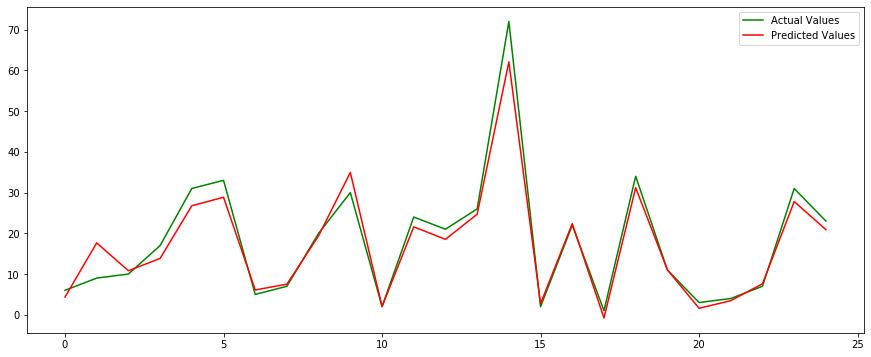

In [41]:
results = estimator.predict(eval_dataset)
 
Yout_ = [result["Yout"] for result in results]
 
actual = Y_test[:, -1]

fig, ax = plt.subplots(figsize=(15,6))
 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(actual, label="Actual Values", color='green')
plt.plot(Yout_, label="Predicted Values", color='red', )
plt.legend()
 
plt.show()

In [31]:
def eval_set_sj():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_sj, Y_sj))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels


def eval_set_iq():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_iq, Y_iq))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [32]:
submission_labels = pd.read_csv('./submissions/submission_benchmark.csv', index_col=[0,1,2])
submission_labels_sj = submission_labels.loc['sj']
submission_labels_iq = submission_labels.loc['iq'][0:150]

Y_sj = submission_labels_sj['total_cases'].values
Y_sj = Y_sj.astype(np.float32)

Y_iq = submission_labels_iq['total_cases'].values
Y_iq = Y_iq.astype(np.float32)

X_sj = np.roll(Y_sj, 1)
X_iq = np.roll(Y_iq, 1)

#final submissions for sj and iq
Y_sj_final = Y_sj
Y_iq_final = Y_iq
remainder_iq = submission_labels.loc['iq'][150:156]


In [33]:
X_sj = np.reshape(X_sj, [-1, SEQLEN])
Y_sj = np.reshape(Y_sj, [-1, SEQLEN])
 
X_iq = np.reshape(X_iq, [-1, SEQLEN])
Y_iq = np.reshape(Y_iq, [-1, SEQLEN])

Y_sj_final = np.reshape(Y_sj_final, [-1, SEQLEN])
Y_iq_final = np.reshape(Y_iq_final, [-1, SEQLEN])


In [34]:
#predic values for SJ
results = estimator.predict(eval_set_sj)
Yout_ = [result["Yout"][0] for result in results]

#assigning values of sj predictions to the y_sj_final array
for i in range(26):
    if(Yout_[i] > 0):
        Y_sj_final[i][9] = Yout_[i]
    else:
        Y_sj_final[i][9] = 0


results = estimator.predict(eval_set_iq)
Yout_ = [result["Yout"][0] for result in results]

for i in range(15):
    if(Yout_[i] > 0):
        Y_iq_final[i][9] = Yout_[i]
    else:
        Y_iq_final[i][9] = 0


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [35]:
for k in range(9):
    Y_sj = np.roll(Y_sj, 1)
    X_sj = np.roll(X_sj, 1)
    Y_iq = np.roll(Y_iq, 1)
    X_iq = np.roll(X_iq, 1)

    Y_sj_final = np.roll(Y_sj_final, 1)
    Y_iq_final = np.roll(Y_iq_final, 1)

    #predic values for SJ
    results = estimator.predict(eval_set_sj)
    Yout_ = [result["Yout"][0] for result in results]

    #assigning values of sj predictions to the y_sj_final array
    for i in range(26):
        if(Yout_[i] > 0):
            Y_sj_final[i][9] = Yout_[i]
        else:
            Y_sj_final[i][9] = 0


    results = estimator.predict(eval_set_iq)
    Yout_ = [result["Yout"][0] for result in results]

    for i in range(15):
        if(Yout_[i] > 0):
            Y_iq_final[i][9] = Yout_[i]
        else:
            Y_iq_final[i][9] = 0
            

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir\model.ckpt-42000
INFO:tensorflow:Running loc

In [36]:
Y_sj_final = np.roll(Y_sj_final, -9) 
final_sj = Y_sj_final.reshape(260)
df_sj = pd.DataFrame(final_sj, columns=['total_cases'])

In [37]:
Y_iq_final = np.roll(Y_iq_final, -9) 
final_iq = Y_iq_final.reshape(150)
df_iq = pd.DataFrame(final_iq, columns=['total_cases'])

df_iq = np.concatenate([df_iq, remainder_iq])

In [38]:
final_submission = np.concatenate([df_sj, df_iq])
final_submission = final_submission.astype(np.int64)

submission = pd.read_csv("./submissions/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = final_submission

Text(0.5, 0, 'Time')

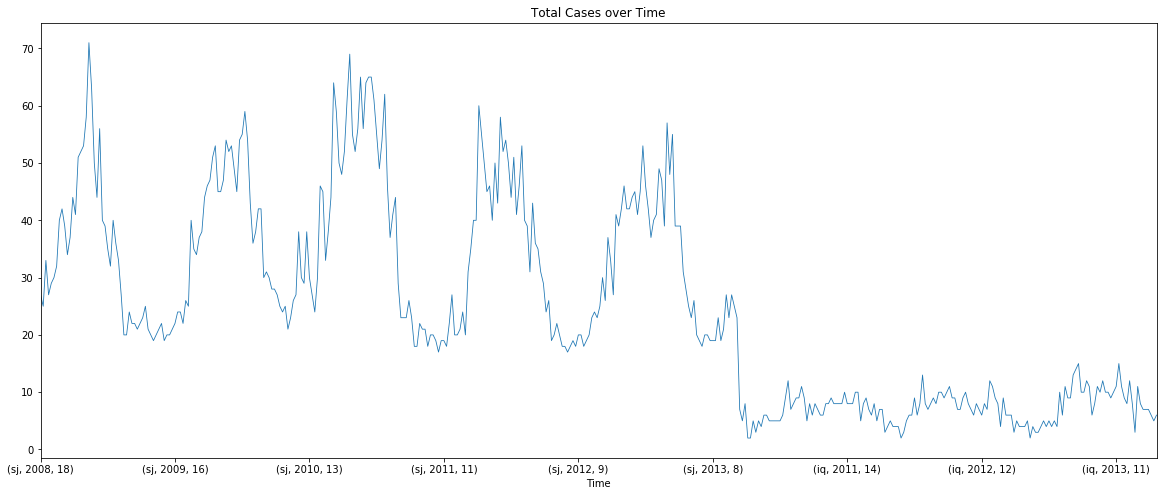

In [39]:
fig, ax = plt.subplots(figsize=(20,8))
(submission_labels
     .total_cases
     .plot
     .line(lw=0.8))

plt.title('Total Cases over Time')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

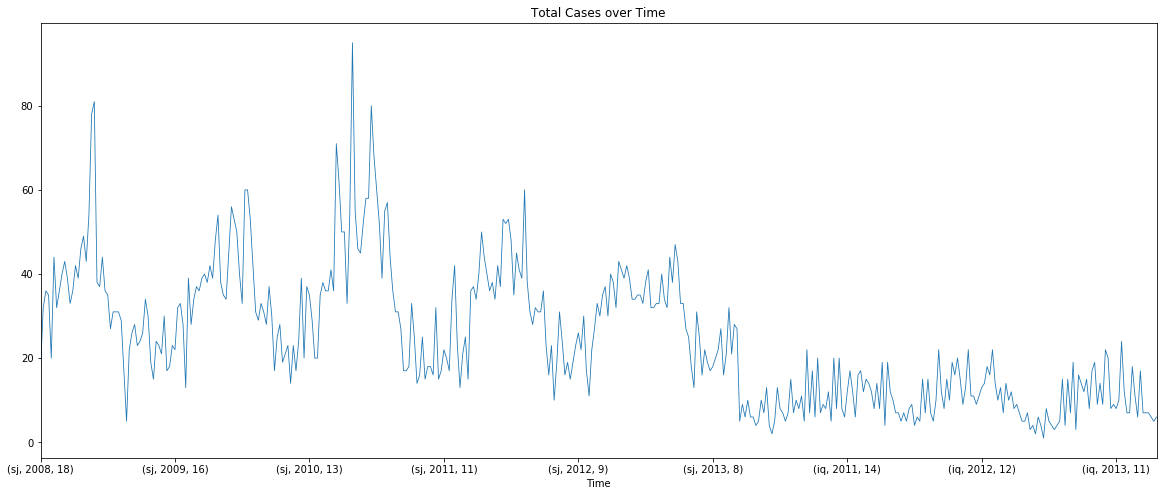

In [40]:
fig, ax = plt.subplots(figsize=(20,8))
(submission
     .total_cases
     .plot
     .line(lw=0.8))

plt.title('Total Cases over Time')
plt.xlabel('Time')

In [ ]:
submission.to_csv("./benchmark.csv")